# Import modules and Preprocessing

In [58]:
import pandas as pd
import cv2
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

from tqdm import tqdm

Load images

In [59]:
dataset_root_folder = './flowers'

x_image = []
y_label = []
img_size = (150, 150)

# get a list of all folders inside "flowers" directory
labels = os.listdir(dataset_root_folder)

# get all images in all subfolders
for dirname in labels:
	filepath = os.path.join(dataset_root_folder, dirname)
	for file in os.listdir(filepath):
		filename = os.path.join(filepath, file)
		# load image
		image = cv2.imread(filename)
		image = cv2.resize(image, img_size)
		x_image.append(np.array(image))
		y_label.append(dirname)

### Normalization on pixel values of images

In [60]:
X = np.array(x_image)
X = X/255
X.shape

(4317, 150, 150, 3)

### Label Encoding

In [61]:
# Encode labels into numbers
le = LabelEncoder()
Y = le.fit_transform(y_label)

# One-hot encoding
Y = tf.keras.utils.to_categorical(Y, 5)
Y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### Split dataset into training, validation, and test

In [62]:
seed = 321

# To keep track of shuffled data and their indices to refer to the image
indexes_for_split = [x for x in range(len(X))]
_, test_label_indexes, ___, ____ = train_test_split(indexes_for_split, Y, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)

# Actual train test split of data
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=seed, shuffle=True, stratify=y_train_val)

### Setting the random seed

In [63]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# CNN

### Build the model

In [64]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding="Same", activation="relu", input_shape = (150, 150, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding="Same", activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))

model.add(Conv2D(filters = 96, kernel_size = (3, 3), padding="Same", activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))

model.add(Conv2D(filters = 96, kernel_size = (3, 3), padding="Same", activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(5, activation = "softmax"))

Using a LR Annealer

In [65]:
batch_size = 128
epochs = 50

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.1)

Data augmentation

In [66]:
datagen = ImageDataGenerator(
    featurewise_center=False,       # set input mean to 0 over the dataset
    samplewise_center=False,        # set each sample mean to 0
    featurewise_std_normalization=False,        # divide inputs by std of dataset
    samplewise_std_normalization=False,         # divide each input by its std
    zca_whitening=False,        # apply ZCA whitening
    rotation_range=10,          # randomly rotate images int he range (degrees, 0 to 180)
    zoom_range=0.1,             # randomly zoom image
    width_shift_range=0.2,      # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,     # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
)

datagen.fit(x_train)

Compile model and get summary

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 18, 18, 96)      

k:\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training the model

In [68]:
start_time = time.time()
History = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_val, y_val),
    verbose=1,
    steps_per_epoch= x_train.shape[0] // batch_size
)
duration = time.time() - start_time
print()
print("Training time:", duration, 'seconds')

L:\Windows\Temp/ipykernel_43212/75248312.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(


Epoch 1/50
20/20 [==============================] - 12s 593ms/step - loss: 1.5553 - accuracy: 0.3027 - val_loss: 1.3185 - val_accuracy: 0.3854
Epoch 2/50
20/20 [==============================] - 11s 567ms/step - loss: 1.2468 - accuracy: 0.4584 - val_loss: 1.0661 - val_accuracy: 0.5590
Epoch 3/50
20/20 [==============================] - 11s 529ms/step - loss: 1.1663 - accuracy: 0.5234 - val_loss: 1.0563 - val_accuracy: 0.5706
Epoch 4/50
20/20 [==============================] - 12s 580ms/step - loss: 1.1088 - accuracy: 0.5372 - val_loss: 1.0447 - val_accuracy: 0.5949
Epoch 5/50
20/20 [==============================] - 11s 565ms/step - loss: 1.0092 - accuracy: 0.6042 - val_loss: 0.9800 - val_accuracy: 0.6088
Epoch 6/50
20/20 [==============================] - 11s 552ms/step - loss: 0.9915 - accuracy: 0.6071 - val_loss: 0.8836 - val_accuracy: 0.6539
Epoch 7/50
20/20 [==============================] - 11s 566ms/step - loss: 0.9347 - accuracy: 0.6331 - val_loss: 0.8947 - val_accuracy: 0.6389

Save the model

In [69]:
model.save('my_model.h5')

### Evaluate the model performance on training

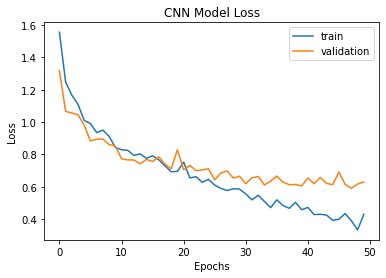

In [70]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title("CNN Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

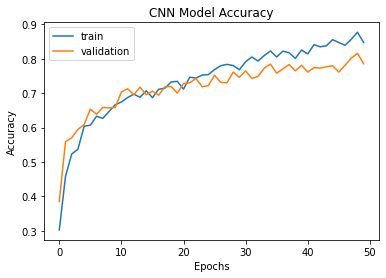

In [71]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title("CNN Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#### Evaluate the accuracy of the best model on the test set

Make prediction on test set

In [72]:
start_time = time.time()
y_pred = model.predict(x_test)
duration = time.time() - start_time

# Convert one hot format into the index of the selected label
y_pred_digits = np.argmax(y_pred, axis=1)
y_num_test = np.argmax(y_test, axis=1)

# print("accuracy on test dataset =", best_mlp_score)
print("time taken to execute =", duration, 'seconds')

time taken to execute = 0.6942403316497803 seconds


Evaluate accuracy

In [73]:
res = model.evaluate(x_test, y_test)
print("Model accuracy on test set:", res[1])

27/27 [==============================] - 0s 13ms/step - loss: 0.5646 - accuracy: 0.8183
Model accuracy on test set: 0.8182870149612427


Confusion matrix

Text(33.0, 0.5, 'Truth')

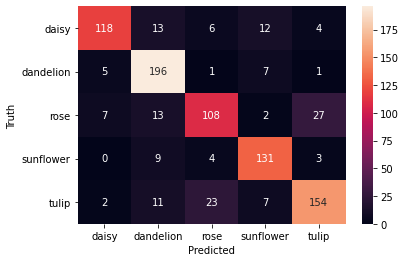

In [74]:
cm = confusion_matrix(y_num_test, y_pred_digits)
# Get all unique labels from the test set
cm_labels = np.unique(y_label)
# Connect the confusion matrix indices with the proper text labels
cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

# Plot confusion matrix in a heatmap
sns.heatmap(cm_array_df, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth') 

Examples of correctly classified flowers

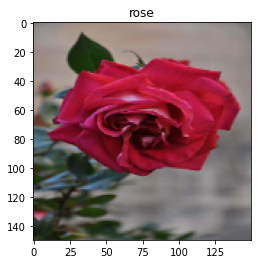

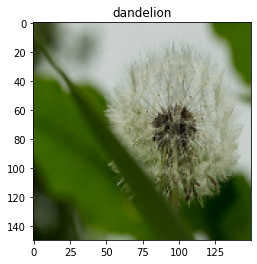

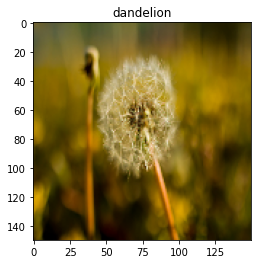

In [75]:
images_to_show = 3

# Find the indexes of the correctly classified flowers
indexes = []
for i, pred_flower in enumerate(y_pred_digits):
        if pred_flower == y_num_test[i]:
            indexes.append(i)
            # Break out of loops if already found enough samples
            if len(indexes) >= images_to_show:
                break

for i in indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(cm_labels[np.argmax(y_test[i])])
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()

Examples of wrongly classified flowers

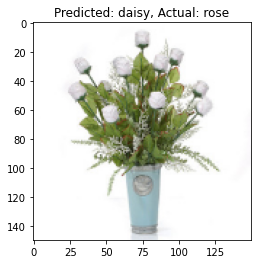

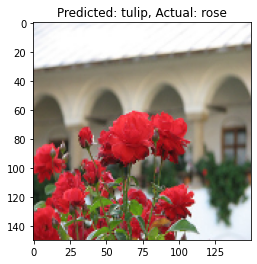

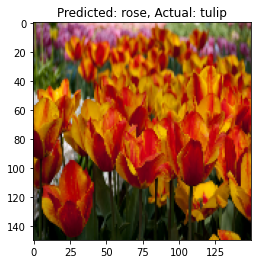

In [76]:
images_to_show = 3

# Find the indexes of the wrongly classified flowers
wrong_indexes = []
for i, pred_flower in enumerate(y_pred_digits):
        if pred_flower != y_num_test[i]:
            wrong_indexes.append(i)
            # Break out of loops if already found enough samples
            if len(wrong_indexes) >= images_to_show:
                break

for i in wrong_indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(f'Predicted: {cm_labels[y_pred_digits[i]]}, Actual: {cm_labels[np.argmax(y_test[i])]}')
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()